# Demo： Deep neural network + Bayesian neural network

- This architecture is widely used across the literature, for instance ref [1](https://www.sciencedirect.com/science/article/pii/S0021999121002564). It uses a deep nueral network as the low-fidelity model and use another Bayesian neural network to transfer the low-fidelity DNN to high-fidelity directly together with HF dataset. 

<center><img src="figures/dnn_bnn_schematic.png" width="50%"> </center>
<center> Figure: Illustration of Neural Architecture of DNN-BNN </center>
<br>


In [ ]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import torch


from mfbml.problems import MengCase1
from mfbml.methods.dnn_bnn import DNNBNN

# fix the random seed for reproducibility
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## Define the problem and get dataset

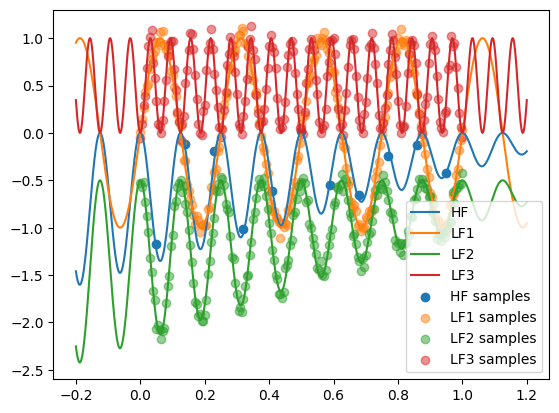

In [2]:
func = MengCase1(noise_std=0.0)
# generate samples (11 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = torch.linspace(0.05, 0.95, 11).reshape(-1, 1)
# add the end points

# training configure
samples = [hf_samples, lf_samples]

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)
# generate the test points
test_samples = torch.linspace(-0.2, 1.2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# dataset of lf1 and hf
responses_lf1 = [hf_responses, lf1_responses]
# dataset of lf2 and hf
responses_lf2 = [hf_responses, lf2_responses]
# dataset of lf2 and hf
responses_lf3 = [hf_responses, lf3_responses]

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless,   label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless,  label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless,  label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, alpha=0.5, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, alpha=0.5,  label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, alpha=0.5, label="LF3 samples")

plt.legend()
plt.show()

## Configurations for DNN and BNNs


In [5]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 2000,
    "print_iter": 100,
    "data_split": True,
}
hf_train_config = {
    "num_epochs": 20000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 10000,
}

# Training and prediction of DNN-BNN model


In [6]:
# initialize the DNNBNN model
model = DNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_configure,
)

# train the model with corresponding samples and responses 
model.train(
    X=samples,
    Y=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  100 train loss:  0.9641502499580383 test loss:  0.9320565462112427
epoch:  200 train loss:  0.9632527232170105 test loss:  0.9323705434799194
epoch:  300 train loss:  0.9614452123641968 test loss:  0.9324723482131958
epoch:  400 train loss:  0.9452740550041199 test loss:  0.9355612993240356
epoch:  500 train loss:  0.8461481332778931 test loss:  0.9804154634475708
epoch:  600 train loss:  0.7155946493148804 test loss:  0.8462830781936646
epoch:  700 train loss:  0.5507971048355103 test loss:  0.5913920998573303
epoch:  800 train loss:  0.2738052308559418 test loss:  0.25337082147598267
epoch:  900 train loss:  0.05231728032231331 test loss:  0.029175981879234314
epoch:  1000 train loss:  0.03982255235314369 test loss:  0.01840062625706196
epoch:  1100 train loss:  0.032646384090185165 test loss:  0.015421103686094284
epoch:  1200 train loss:  0.02712378278374672 test loss:  0.013747702352702618
epoch:  1300 train loss:  0.020740721374750137 test loss:  0.011612605303525925
epoc

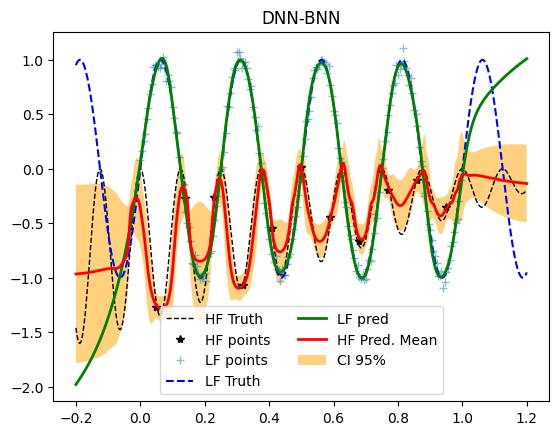

In [14]:
# visualize the posterior of sequential mf-bnn
(
    pred_hy,
   pred_epistemic,
    pred_total_unc,
   pred_aleatoric,
) = model.predict(X=test_samples)
# get lf predictions
pred_ly = model.predict_lf(X=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
        'k--',
    linewidth=1,
    label="HF Truth",
)

ax.plot(hf_samples, hf_responses, "k*", label="HF points")
# plot lf samples
ax.plot(lf_samples, lf1_responses, '+',  label="LF points", alpha=0.5)
# plot the true lf1
ax.plot(test_samples.numpy(), test_lf1_responses_noiseless.numpy(), 'b--', label="LF Truth")
ax.plot(test_samples.numpy(), pred_ly,
        'g-', linewidth=2, label="LF pred")
ax.plot(test_samples.numpy(), pred_hy, 'r-', linewidth=2, label="HF Pred. Mean")

ax.fill_between(
    test_samples.flatten().numpy(),
    (pred_hy - 1.96 * pred_total_unc).reshape(-1),
    (pred_hy + 1.96 * pred_total_unc).reshape(-1),
    alpha=0.5,
    label="CI 95%",
    color="orange", 
    edgecolor=None,
)
plt.legend(loc="lower center", ncol=2)
plt.title("DNN-BNN") 
plt.show()

# have fun